In [1]:
from __future__ import print_function, division
#Allows relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports from files
from src.preprocessing import *
from src.train_eval_helpers import *
from src.VAE_train import *

from src.vautoencoders import *
#from loss_metrics import *
from src.plots import *
from src.pickling import *
from src.datasets import *

import pandas as pd 
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))
    
#Plot and stuff
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
sns.set_style('darkgrid')


# Ignore warnings)
import warnings
warnings.filterwarnings("ignore")
    
%load_ext autoreload
%autoreload 2

Using : cuda


In [2]:
train_dataset, valid_dataset, test_dataset  = load_naive_dataset('../training_data_new/db_TRB.csv')

## Now, try to reproduce and retrain the best model I got (no manual tuning)
- with the full dataset and smaller LR
- latent dim = 40
- act = nn.SELU()
- weight decay ~= LR
- weighted labeling (= 1.6)

In [5]:
autoencoder = AutoEncoder(latent_dim = 40, aa_dim = 21, 
                             seq_len = 23, act = nn.SELU())

autoencoder.to(device)
# Reloading the best weight
best_chkpt = torch.load('./Best_AE_model_latdim40_withSELU.pth.tar')
autoencoder.load_state_dict(best_chkpt['state_dict'])

<All keys matched successfully>

In [6]:
print('\n#######################\n\nTest set')
test_decode(autoencoder, test_dataset, 10)


#######################

Test set

real:		CSVEEDNRDTEAFFXXXXXXXXX
decoded:	CSVEEDNRDTEAFFXXXXXXXXX

real:		CARDPNGGGGGGVTEAFFXXXXX
decoded:	CARDPXGGGGGGNTEQFFXXXXX

real:		CAGSPEFSGAEETQYFXXXXXXX
decoded:	CAGSPEXSGAQETQYFXXXXXXX

real:		CASSQLREGPDERVFXXXXXXXX
decoded:	CASSQLREGXXERFFXXXXXXXX

real:		CSAETGLAYGYTFXXXXXXXXXX
decoded:	CSAETGLAYGYTFXLXXXXXXXX

real:		CASSCRGLAGGPDTQYCXXXXXX
decoded:	CASSXRGLAGGPETQYFXXXXXX

real:		YASSPHTTSTETQYFXXXXXXXX
decoded:	YASSPXTTSTETQYFXXXXXXXX

real:		CASIKYQGSTGELFFXXXXXXXX
decoded:	CASIXXQGSTGELFFXXXXXXXX

real:		CAISKDPPGTDTQYFXXXXXXXX
decoded:	CAISXDPPGTDTQYFXXXXXXXX

real:		CASSPEGGQGAIGANVLTFXXXX
decoded:	CASSPEGGQGAGGXNXLXFXXXX


(array(['CSVEEDNRDTEAFFXXXXXXXXX', 'CARDPNGGGGGGVTEAFFXXXXX',
        'CAGSPEFSGAEETQYFXXXXXXX', 'CASSQLREGPDERVFXXXXXXXX',
        'CSAETGLAYGYTFXXXXXXXXXX', 'CASSCRGLAGGPDTQYCXXXXXX',
        'YASSPHTTSTETQYFXXXXXXXX', 'CASIKYQGSTGELFFXXXXXXXX',
        'CAISKDPPGTDTQYFXXXXXXXX', 'CASSPEGGQGAIGANVLTFXXXX'], dtype=object),
 array(['CSVEEDNRDTEAFFXXXXXXXXX', 'CARDPXGGGGGGNTEQFFXXXXX',
        'CAGSPEXSGAQETQYFXXXXXXX', 'CASSQLREGXXERFFXXXXXXXX',
        'CSAETGLAYGYTFXLXXXXXXXX', 'CASSXRGLAGGPETQYFXXXXXX',
        'YASSPXTTSTETQYFXXXXXXXX', 'CASIXXQGSTGELFFXXXXXXXX',
        'CAISXDPPGTDTQYFXXXXXXXX', 'CASSPEGGQGAGGXNXLXFXXXX'], dtype=object))

In [10]:
[x for x in train_dataset if x.startswith('CASSF')]

['CASSFERQANTEAFF',
 'CASSFPPGAYGYTF',
 'CASSFGHGLNEKLFF',
 'CASSFRTKTDTQYF',
 'CASSFYELNTEAFF',
 'CASSFISSGVGETQYF',
 'CASSFVGTGVGSNQPQHF',
 'CASSFKQGWFGTGVFF',
 'CASSFAWGNYEQYF',
 'CASSFGALTQSYEQYF',
 'CASSFWAGNTIYF',
 'CASSFRDFQETQYF',
 'CASSFGTANQPQHF',
 'CASSFVSGRVYEQFF',
 'CASSFIPPGEGLYYGYTF',
 'CASSFSPGRPQHF',
 'CASSFGFGASGNVEQFF',
 'CASSFKGDRDTQYF',
 'CASSFRQGSNTGELFF',
 'CASSFRLPYEQYF',
 'CASSFRYEQYF',
 'CASSFDGPGPGQYF',
 'CASSFKTRDNEQFF',
 'CASSFSPGRENYGYTF',
 'CASSFRLGLSNQPQHF',
 'CASSFPPGGGNEQFF',
 'CASSFQRGRRNEQFF',
 'CASSFLESGANVLTF',
 'CASSFPSGGSYNEQFF',
 'CASSFPGGCNQPQHF',
 'CASSFELAGALTDTQYF',
 'CASSFRTTDTQYF',
 'CASSFAPRDTQYF',
 'CASSFSGYDGYTF',
 'CASSFGFSGGTYEQYF',
 'CASSFLSGNEQFF',
 'CASSFLGSLEGRTQYF',
 'CASSFSAPSEQYF',
 'CASSFGGGAEDTQYF',
 'CASSFEANYGYTF',
 'CASSFFLRGRTGTGGETQYF',
 'CASSFGLAGPITDTQYF',
 'CASSFRQGPDTQYF',
 'CASSFSQFNEQFF',
 'CASSFSPPQGGPYGYTF',
 'CASSFRRSNEQFF',
 'CASSFGVGAYRQPQHF',
 'CASSFSLAGYADTQYF',
 'CASSFPAGARNTEAFF',
 'CASSFQGAEETQYF',
 'CASS

In [47]:
# Is there a similarity measure possible ?? 
# Given the amino acid groups, some amino acid are more similar than to others
# Like Leucine vs Isoleucine (I, L) or other aromatic amino acids (F, W ,Y)
# (THIS DOESNT work AT ALL)
df = pd.DataFrame()
def get_seq(aa = ''):
    return 'CASSF' + 2*aa + 'TEQYF'

embds = []
for aa in ['F','W','Y', 'I', 'L' ,'E' ,'D']:
    s = get_seq(aa)
    embed, _ = autoencoder(onehot_batch(s, max_len = 23, weighted = 1.6).to(device))
    embds.append(embed.cpu().detach().numpy())
    df = df.append(pd.DataFrame(data=[[s, 2*aa]], columns = ['sequence', 'central']), ignore_index =True)
df

,sequence,central
0,CASSFFFTEQYF,FF
1,CASSFWWTEQYF,WW
2,CASSFYYTEQYF,YY
3,CASSFIITEQYF,II
4,CASSFLLTEQYF,LL
5,CASSFEETEQYF,EE
6,CASSFDDTEQYF,DD


<AxesSubplot:xlabel='UMAP_1', ylabel='UMAP_2'>

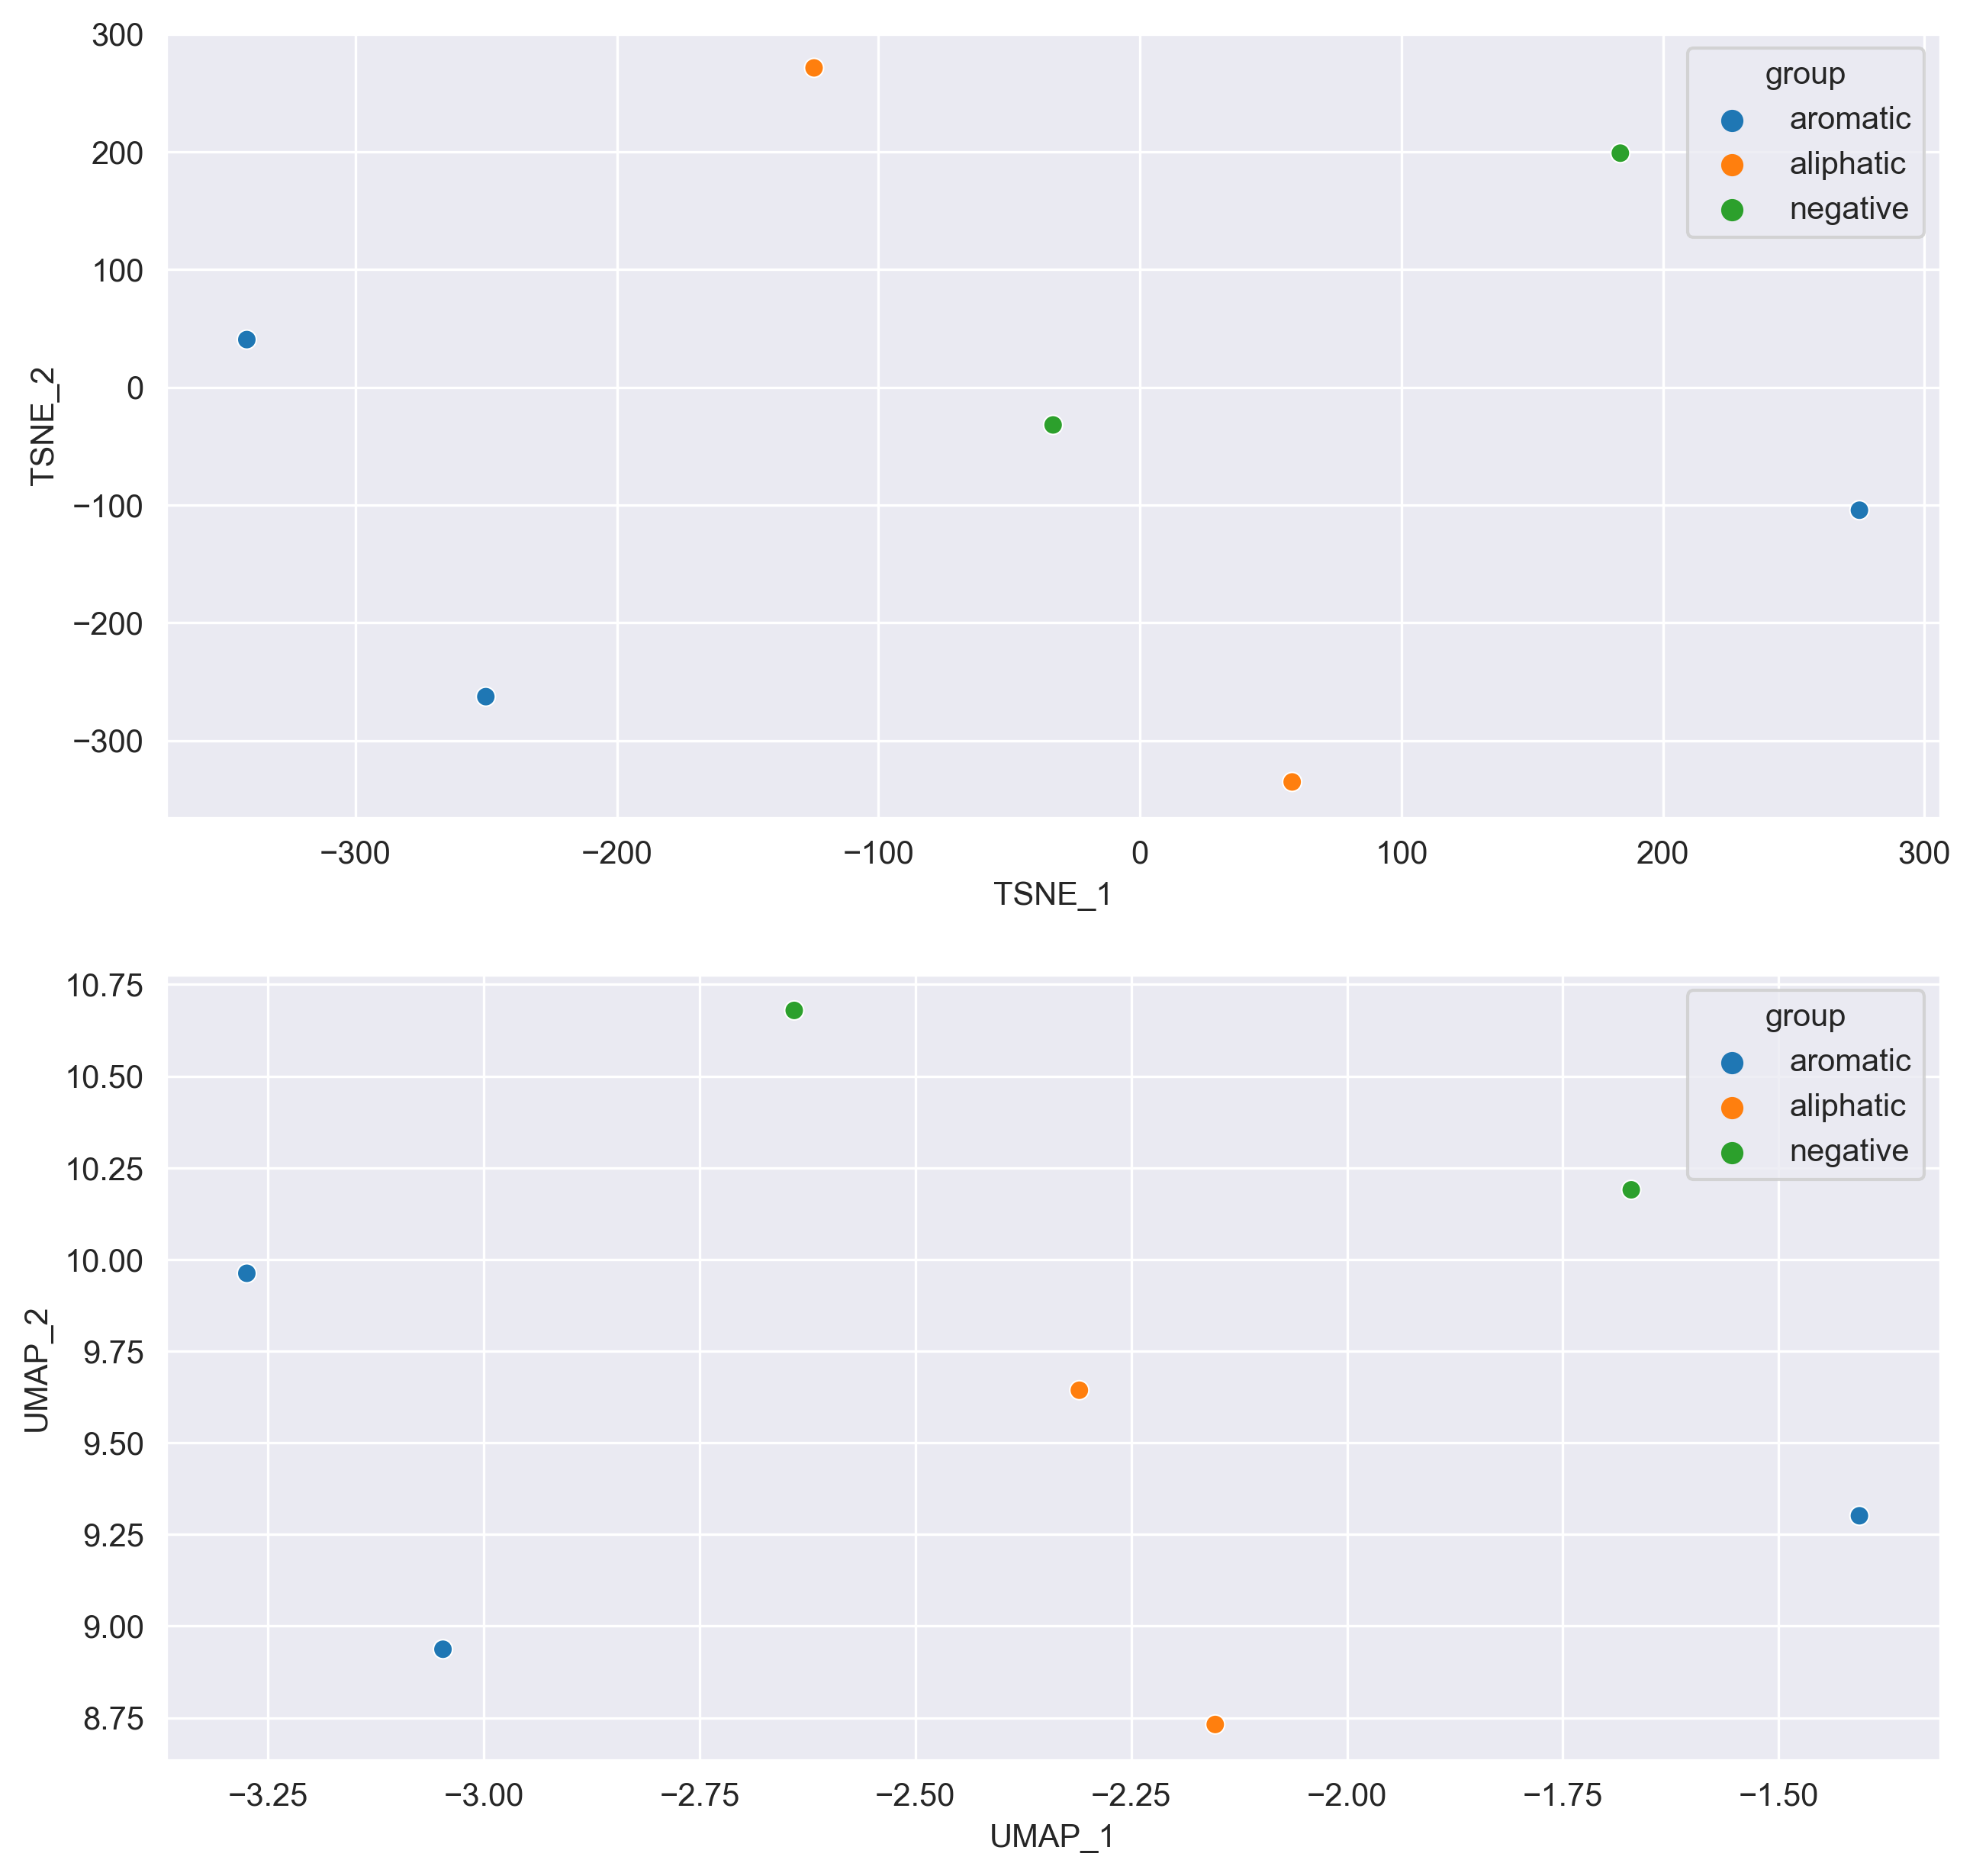

In [61]:
from sklearn.manifold import TSNE
from umap import UMAP
tsne = TSNE(n_components = 2)
umap = UMAP(n_components = 2)

df.loc[0:3,'group'] = 'aromatic'
df.loc[3:5,'group'] = 'aliphatic'
df.loc[5:,'group'] = 'negative'
seq = df.sequence.values
oh = onehot_batch(seq, max_len=23, weighted=1.6)
emb, _ = autoencoder(oh.to(device))
res = tsne.fit_transform(emb.detach().cpu())
df['TSNE_1'] = res[:,0]
df['TSNE_2'] = res[:,1]
res = umap.fit_transform(emb.detach().cpu())
df['UMAP_1'] = res[:,0]
df['UMAP_2'] = res[:,1]

f,a = plt.subplots(2,1, figsize=(10,10))
sns.scatterplot(data=df, x='TSNE_1', y='TSNE_2', hue = 'group', ax = a[0])
sns.scatterplot(data=df, x='UMAP_1', y='UMAP_2', hue = 'group', ax = a[1])

### Then, combine with DeepRC and check prediction ? 

In [9]:
from src.DeepRC_mod import *
class DeepRC_CMV(nn.Module): 
    
    def __init__(self, #20 for the initial onehot encode dim
                 embedding_net: torch.nn.Module = AutoEncoder(latent_dim = 40, aa_dim = 21, 
                                                              seq_len = 23, act = nn.SELU()).encoder,
                 attention_net: torch.nn.Module = AttentionNetwork(n_input_features = 40, 
                                                                   n_layers=2, n_units = 32),
                 output_net: torch.nn.Module = OutputNetwork(n_input_features=40, 
                                                             n_output_features = 21,
                                                              n_layers = 2, n_units = 32),
freeze_encoding = True
                ):
        super(DeepRC_AutoEncoder, self).__init__()
        self.embedding = embedding_net.to(dtype=torch.float32)
        
        self.feature_extractor = nn.Sequential(nn.Conv1d(1,8,20, bias=True),
                                               nn.SELU(),
                                               nn.Conv1d(8,16,20, bias=True),
                                               nn.MaxPool1d(2),
                                               nn.ReLU())
        # #Freezing encoding layer, maybe unfreeze later
        # if freeze_encoding:
        for p in self.embedding.parameters():
            p.requires_grad = False
                
        self.attention = attention_net.to(dtype=torch.float32)
        self.out = output_net.to(dtype=torch.float32)
        
    def forward(self, x, n_per_bag):
        seq_embed = self.embedding(x.view(-1, 23*21)) #should be shape (N, latent_dim)
        seq_embed = self.feature_extractor(seq_embed)
        seq_attention = self.attention(seq_embed)
        # BUT softmax(attn_weight) must be done PER BAG. Given we have the number of sequences,
        #we treat the input (A sequence of bags) sequentially : 
        
        x = []
        start_i = 0
        # n_per_bag stores the number of sequences per bag, so we can use it to slice the attention and embedding
        for n_seqs in n_per_bag : 
            #SLICE AND SOFTMAX OVER THE SLICE
            attention_slice = torch.softmax(seq_attention[start_i:start_i+n_seqs], dim=0)
            embedding_slice = seq_embed[start_i:start_i+n_seqs]
            
            embedding_attention = embedding_slice * attention_slice
            #Weighted sum over the features. The Weight is from the attention
            x.append(embedding_attention.sum(dim=0))
            start_i += n_seqs
            del embedding_attention
            
        x = torch.stack(x, dim = 0)
        predicted = self.out(x)
        return predicted

encoder = autoencoder.encoder

attn = AttentionNetwork(n_input_features=16,
                           n_layers=2,
                           n_units=64)
out_a = OutputNetwork(n_input_features=16, 
                      n_output_features=2,
                      n_layers=2,
                      n_units=32)

AutoEncoder_DeepRC = DeepRC_AutoEncoder(encoder, attn, out, freeze_encoding=True)

In [13]:
#Datasets
from src.datasets import * 
from src.DeepRC_mod import *
train_data = EmersonDataset('../training_data_new/emerson_raw/batch1/emerson_batch1_train_top10k_hla.tsv',
                            max_len = 23, scale_by_freq=True)
test_data = EmersonDataset('../training_data_new/emerson_raw/batch1/emerson_batch1_test_top10k_hla.tsv',
                            max_len = 23, scale_by_freq = True)

In [14]:
from datetime import datetime as dt
start_time = dt.now()

train, val = train_data.random_split(val_size=0.3)
del train_data #Once split, we don't need the original Dataset object anymore
end_time = dt.now()       
elapsed = divmod((end_time-start_time).total_seconds(), 60)
print(f"\nTime elapsed:\n\t{elapsed[0]} minutes\n\t{elapsed[1]} seconds to do a split lol")


Time elapsed:
	0.0 minutes
	40.274042 seconds to do a split lol


In [3]:
import pandas as pd
x=pd.read_csv('../training_data_new/emerson_raw/batch1/emerson_batch1_626hla_parsed_tagged.tsv', 
              sep='\t')
x

,amino_acid,frequency,rel_freq,v_family,v_gene,d_family,d_gene,j_family,j_gene,filename,pred_cmv,true_cmv,age,sex,race,hla_a1,hla_a2,hla_b1,hla_b2,len
0,CATTGTSGGPSQSTQYF,0.010946,1.000000,TCRBV10,TCRBV10-03,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-03,HIP00110.tsv,0,0,55,Male,Unknown,A03,A24,B07,Unknown,17
1,CASSLRVGGYGYTF,0.010841,0.990413,TCRBV07,TCRBV07-09,TCRBD02,TCRBD02-01,TCRBJ01,TCRBJ01-02,HIP00110.tsv,0,0,55,Male,Unknown,A03,A24,B07,Unknown,14
2,CASRRLGGLNTEAFF,0.006130,0.559999,TCRBV25,TCRBV25-01,TCRBD02,TCRBD02-01,TCRBJ01,TCRBJ01-01,HIP00110.tsv,0,0,55,Male,Unknown,A03,A24,B07,Unknown,15
3,CASSLRGSGNTIYF,0.003510,0.320633,TCRBV05,TCRBV05-01,TCRBD02,TCRBD02-01,TCRBJ01,TCRBJ01-03,HIP00110.tsv,0,0,55,Male,Unknown,A03,A24,B07,Unknown,14
4,CASRQDGSTEAFF,0.003188,0.291286,TCRBV06,TCRBV06-01,TCRBD02,TCRBD02-01,TCRBJ01,TCRBJ01-01,HIP00110.tsv,0,0,55,Male,Unknown,A03,A24,B07,Unknown,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24558229,CASSLMGGTNTGELFF,0.000003,0.000097,TCRBV07,TCRBV07-06,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-02,HIP19717.tsv,1,1,48,Male,Unknown,A01,Unknown,B18,B35,16
24558230,CASSLTGESGYTF,0.000003,0.000097,TCRBV06,TCRBV06-01,TCRBD01,TCRBD01-01,TCRBJ01,TCRBJ01-02,HIP19717.tsv,1,1,48,Male,Unknown,A01,Unknown,B18,B35,13
24558231,CASSRGQQSIPYEQYF,0.000003,0.000097,TCRBV07,TCRBV07-09,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-07,HIP19717.tsv,1,1,48,Male,Unknown,A01,Unknown,B18,B35,16
24558232,CASSPEGAGGFGVQYF,0.000003,0.000097,TCRBV07,TCRBV07-09,TCRBD02,TCRBD02-01,TCRBJ02,TCRBJ02-07,HIP19717.tsv,1,1,48,Male,Unknown,A01,Unknown,B18,B35,16


In [15]:
def drc_train_model(model, criterion, optimizer, dataset, mini_batch_size):
    model.train()
    train_loss_a = 0
    train_loss_b = 0
    #Minibatch SGD, get a list of indices to separate the train data into batches 
    for b in tqdm(BatchSampler(RandomSampler(dataset.unique),
                          batch_size = mini_batch_size, drop_last=False), 
                  desc='Train batches',
                 position = 1, leave=False): 
        #Standard train loops
        seq, target_A, target_B, n_per = train.get_patient(train.unique[b])
        #Sending everything to device
        seq = seq.to(device, dtype=torch.float32)
        target_A = target_A.to(device, dtype=torch.float32)
        target_B = target_B.to(device, dtype=torch.float32)
        #Prediction & loss for each label
        pred_a, pred_b = model(seq, n_per)
        loss_A = criterion(pred_a, target_A)
        loss_B = criterion(pred_b, target_B)
        #Optimizer
        model.zero_grad()
        loss = loss_A+loss_B
        loss.backward()
        optimizer.step()
        train_loss_a += loss_A.item()
        train_loss_b += loss_B.item()
        
    train_loss_a /= math.floor(len(dataset.unique)/mini_batch_size)
    train_loss_b /= math.floor(len(dataset.unique)/mini_batch_size)

    return train_loss_a, train_loss_b


def drc_eval_model(model, criterion, dataset, mini_batch_size):
    model.eval()
    val_loss_a = 0
    val_loss_b = 0
    with torch.no_grad():
        for b in tqdm(BatchSampler(RandomSampler(dataset.unique), batch_size = mini_batch_size,
                         drop_last = False), desc = 'Val batches',
                      position = 2, leave=False):
            seq, target_A, target_B, n_per = dataset.get_patient(dataset.unique[b])
            #Sending everything to device
            seq = seq.to(device, dtype=torch.float32)
            target_A = target_A.to(device, dtype=torch.float32)
            target_B = target_B.to(device, dtype=torch.float32)
            pred_a, pred_b = model(seq, n_per)
            val_loss_a += criterion(pred_a, target_A).item()
            val_loss_b += criterion(pred_b, target_B).item()
    val_loss_a /= math.floor(len(dataset.unique)/mini_batch_size)
    val_loss_b /= math.floor(len(dataset.unique)/mini_batch_size)
    return val_loss_a, val_loss_b

  0%|          | 0/30 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train batches:   0%|          | 0/25 [00:00<?, ?it/s]

Val batches:   0%|          | 0/11 [00:00<?, ?it/s]

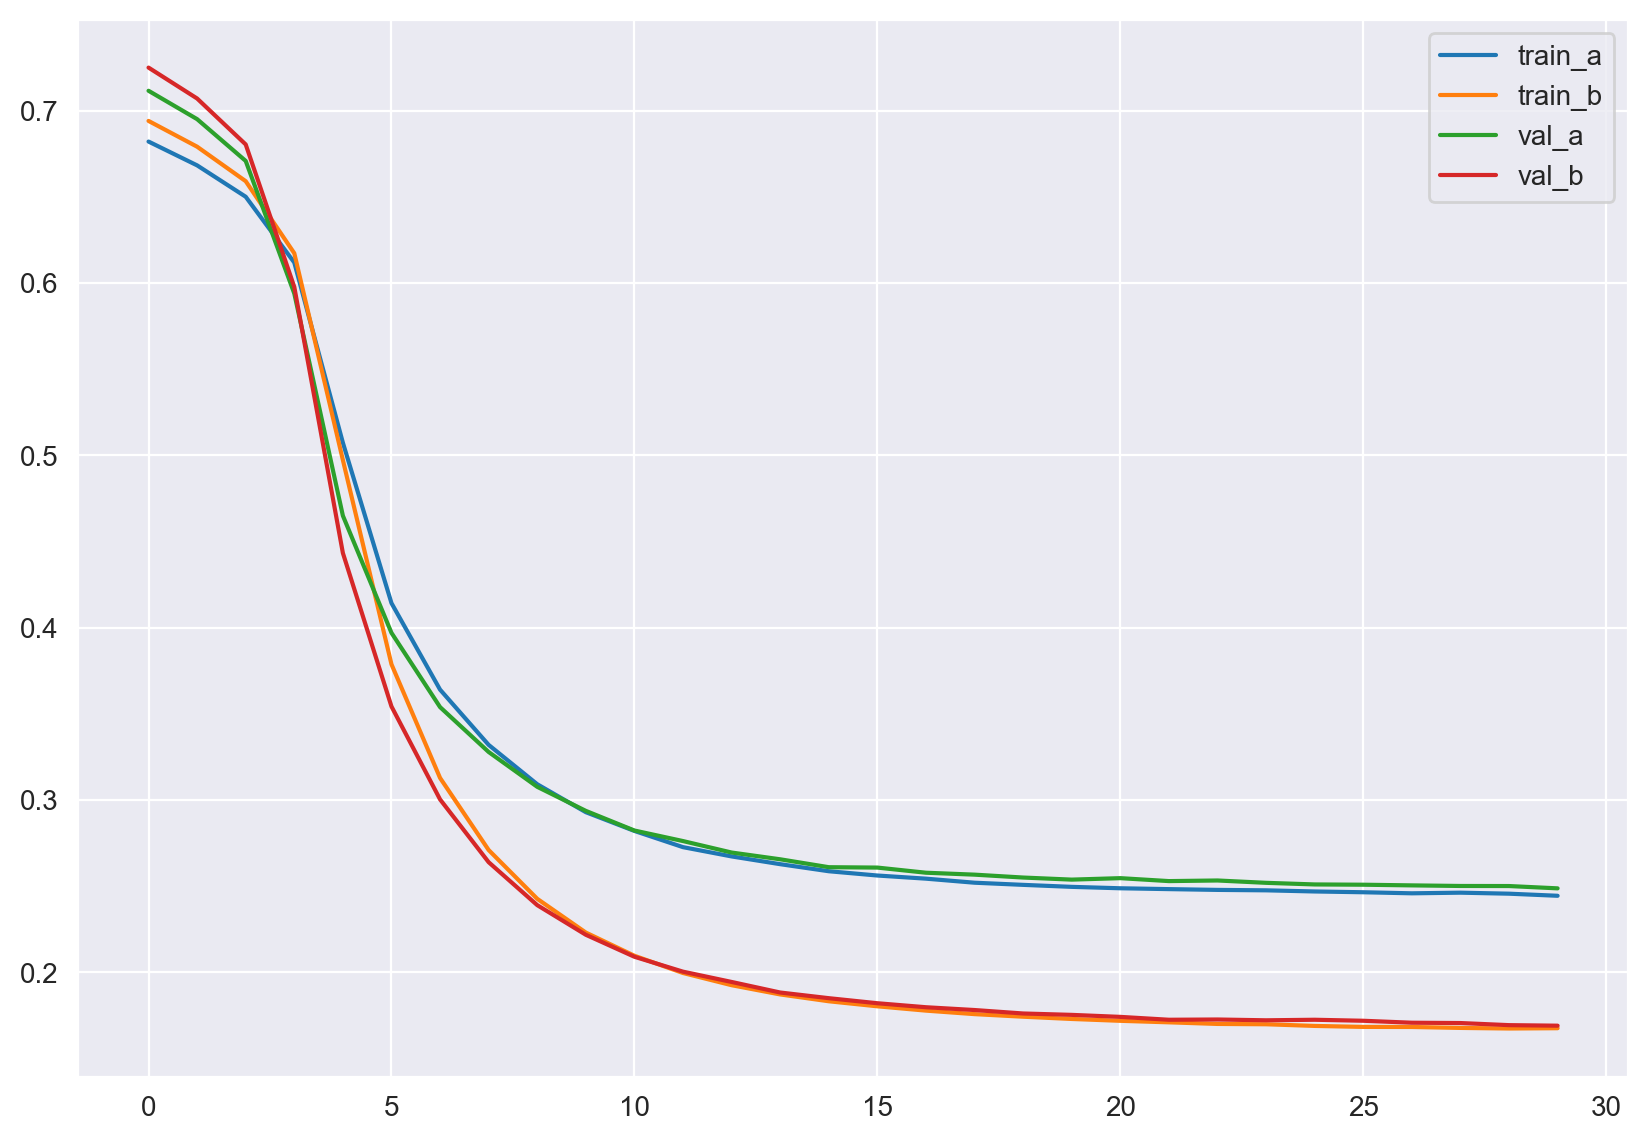

In [24]:
from tqdm.auto import tqdm
#Training stuff
nb_epochs = 30
mini_batch_size = 16 # 16 bags at a time
lr = 1e-4 # the creator used 1e-4
criterion = nn.BCELoss() #Used for multilabel classification + Sigmoid
adam = optim.Adam(params=AutoEncoder_DeepRC.parameters(), lr = lr)
train_losses_a = []
train_losses_b = []
AutoEncoder_DeepRC.to(device)
val_losses_a = []
val_losses_b = [] 

best_a = 100000
best_b = 100000

for e in tqdm(range(nb_epochs),position=0):
    train_loss_a, train_loss_b = drc_train_model(AutoEncoder_DeepRC, criterion, optimizer=adam, dataset=train,
                                      mini_batch_size=mini_batch_size)
    print(f'train loss at {e} epochs: A:\t{train_loss_a:.4e}, B:\t{train_loss_b:.4e}', end='\r')
    train_losses_a.append(train_loss_a)
    train_losses_b.append(train_loss_b)
    #validation
    val_a, val_b = drc_eval_model(AutoEncoder_DeepRC, criterion, dataset=val, 
                              mini_batch_size=mini_batch_size)
    
    if val_a < best_a : best_a = val_a
    if val_b < best_b : best_b = val_b
        
    if e != 0 and np.mean([val_a, val_b]) <= np.mean([best_a, best_b]):
        torch.save({'state_dict':AutoEncoder_DeepRC.state_dict(), 'epoch':e}, './DeepRC_Autoencoder.pth.tar')
        
    val_losses_a.append(val_a)
    val_losses_b.append(val_b)
    print(f'val loss at {e} epochs: A:\t{val_a:.4e}, B:\t{val_b:.4e}', end='\r')
    
losses = {'train_a':train_losses_a,
          'train_b':train_losses_b,
          'val_a' : val_losses_a,
          'val_b' : val_losses_b}
plt.figure(figsize=(10,7))
for k in losses.keys():
    plt.plot(losses[k], label = k)
plt.legend()
save_pkl('./withBestAutoEncoder_frozen_losses.pkl', losses)

In [33]:
from src.VAE_train import test_decode
print('\n#######################\nEMERSON')
test_decode(model_reload, emerson_sub, 10)
print('\n#######################\n\nTest set')
test_decode(model_reload, test_dataset, 10)


#######################
EMERSON

real:		CASSVAGSNDQPQHFXXXXXXXX
decoded:	CASSVAGSNDQPQYFXXXXXXXX

real:		CASSPGAGSEKELFFXXXXXXXX
decoded:	CASSPGAGSXXELFFXXXXXXXX

real:		CASSFGDREPDTQYFXXXXXXXX
decoded:	CASSXGDREXDTQYFXXXXXXXX

real:		CASSRAGAQARETQYFXXXXXXX
decoded:	CASSRAGAQARETQYFXXXXXXX

real:		CASSEVGSNTEAFFXXXXXXXXX
decoded:	CASSEVGSNTEAFFXXXXXXXXX

real:		CASSLGQGSGYEQYFXXXXXXXX
decoded:	CASSLGQGSGYEQYFXXXXXXXX

real:		CASSREGLQETQYFXXXXXXXXX
decoded:	CASSREGLQETQYFXXXXXXXXX

real:		CASSSNVALGTEAFFXXXXXXXX
decoded:	CASSSXVALGTEAFFXXXXXXXX

real:		CASAGGGLADNEQFFXXXXXXXX
decoded:	CASAGGGLADNEQFFXXXXXXXX

real:		CASTYNEKLFFXXXXXXXXXXXX
decoded:	CASTTXEXLFFXXXXXXXXXXXX

#######################

Test set

real:		CASTAGSSYNEQFFXXXXXXXXX
decoded:	CASTAGSSYNEQFFXXXXXXXXX

real:		CASSLEGPLQGPGELFFXXXXXX
decoded:	CASSLEGPLXGPGELFFXXXXXX

real:		CASSPNTETANTEAFFXXXXXXX
decoded:	CASSPXTETANTEXFFXXXXXXX

real:		CAWSVSGMNTEAFFXXXXXXXXX
decoded:	CAWSVSGXNTEAFFXXXXXXXXX

real:		CSVDPLTGYNEQFF

In [262]:
AutoEncoder_DeepRC

DeepRC_AutoEncoder(
  (embedding): Sequential(
    (0): Linear(in_features=483, out_features=241, bias=True)
    (1): SELU()
    (2): Linear(in_features=241, out_features=100, bias=True)
    (3): SELU()
    (4): Linear(in_features=100, out_features=40, bias=True)
  )
  (attention): AttentionNetwork(
    (attention_nn): Sequential(
      (0): Linear(in_features=40, out_features=64, bias=True)
      (1): SELU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SELU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (out_A): OutputNetwork(
    (output_nn): Sequential(
      (0): Linear(in_features=40, out_features=32, bias=True)
      (1): SELU()
      (2): Linear(in_features=32, out_features=21, bias=True)
    )
    (sig): Sigmoid()
    (dropout): Identity()
  )
  (out_B): OutputNetwork(
    (output_nn): Sequential(
      (0): Linear(in_features=40, out_features=32, bias=True)
      (1): SELU()
      (2): Linear(in_features=32, out_features=